# Redoing $\sigma$ calculation for only the stars in the bulge

In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting
from sklearn.linear_model import LinearRegression

%matplotlib inline

h = 0.6774
radiative_efficiency=0.2

# New method: Gravitatioanl potential gradient, calculating $j_{circ}$ at given radius

Note: Be careful with units, need to add in scale factor

In [52]:
from rotate import calc_incl, trans, center

TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
subhalo_id = 0
z = 0
a = 1/(1+z)

with h5py.File(TNGpath+"/groups_0{}".format(snap_num)+"/fof_subhalo_tab_099.0.hdf5", "r") as f:
    header = f["Header"]
    # Box size needed to center coordinates
    box_size = header.attrs["BoxSize"]
    
# need to center coords on subhalo pos
SubhaloCM_pos = il.groupcat.loadSubhalos(TNGpath,snap_num,fields='SubhaloPos')[subhalo_id]
SubhaloCM_vel = il.groupcat.loadSubhalos(TNGpath,snap_num,fields='SubhaloVel')[subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(TNGpath, snap_num, id=subhalo_id, partType=4, fields=fields)
# Shouldn't need mass?
star_coords, star_vel, star_mass, star_pot = Star_Props['Coordinates'], Star_Props['Velocities'], Star_Props['Masses'], Star_Props['Potential']

star_coords = center(star_coords,SubhaloCM_pos,box_size)
star_vel = star_vel - SubhaloCM_vel

# Correcting units, scale factor = 1 for z = 0
star_coords *= a/h # New units: kpc
kpc2km = 3.0857e16 # Conversion rate from kpc to km
star_coords *= kpc2km # New units: km
star_vel *= np.sqrt(a) # New units: km/s
star_pot /= a # New units: (km/s)^2

ri   = 0 * kpc2km  # from 0
ro   = 20 * kpc2km # to 20 kpc
incl = calc_incl(star_coords, star_vel, star_mass, ri, ro) ## rotate based on stars

star_coord_trans = trans(star_coords, incl)
star_vel_trans = trans(star_vel, incl)


## Next step: Sample stars at different radial bins and calculate potential gradient

In [82]:
height = 1 * kpc2km # kpc for height of disk
ri   = 0 * kpc2km  # from 0
ro   = 20 * kpc2km # to 20 kpcs
nbins = 100 # 100 bins from 0 to 20 kpc gives gradient res of 1/5 kpc
n = 50 # Number of stars to require and sample from

bins = np.linspace(ri,ro,nbins)

# Only stars within the height of the disk
disk_mask = (star_coord_trans[:,2] > -height) & (star_coord_trans[:,2] < height)
disk_coords = star_coord_trans[disk_mask]
disk_pot = star_pot[disk_mask]

# radial distance from subhalo center in the xy plane
r = np.sqrt(star_coord_trans[:,0]**2 + star_coord_trans[:,1]**2)
r_disk = r[disk_mask]    

# Potentials at each radial bin
potentials = []

for i in range(len(bins)-1):
    
    # Mask of stars within the current radial bin
    r_mask = (r_disk > bins[i]) & (r_disk < bins[i+1])
    
    # Coordinates, potentials of stars in current bin
    r_bin = disk_coords[r_mask]
    r_pot = disk_pot[r_mask]
    
    # Require at least n stars in the radial bin to consider the radial potential well-defined
    if len(r_bin) < n:
        
        potentials.append(np.nan)
    
    # Otherwise, take the average of the potentials in the bin
    else:
        
        # Sample n potentials in the current radial bin
        # sample = np.random.choice(len(r_bin), size=n, replace=False)
        
        # Calculate mean potential
        potential = np.mean(r_pot)

        # Append to list
        potentials.append(potential)

In [115]:
# Positions in the middle of the bins
pos = np.array([np.mean([bins[n],bins[n+1]]) for n in range(0,len(bins)-1)])

# Calculating the gradient based on positions and potentials
grad = np.gradient(potentials,pos[1]-pos[0])

# Interpolating the gradient function with scipy 
gradient_interp = interp1d(pos, grad, kind='linear', fill_value="extrapolate")

In [116]:
potentials

[-6109959.0,
 -6103898.5,
 -6092309.0,
 -6076212.0,
 -6056530.0,
 -6033597.5,
 -6008640.0,
 -5981522.5,
 -5953110.0,
 -5924457.0,
 -5893900.5,
 -5861920.0,
 -5829744.5,
 -5800228.5,
 -5772546.0,
 -5746434.5,
 -5722874.0,
 -5701207.0,
 -5679414.5,
 -5659321.0,
 -5640378.0,
 -5624273.0,
 -5607495.5,
 -5593037.0,
 -5579819.5,
 -5567446.0,
 -5555360.5,
 -5544160.5,
 -5533470.5,
 -5523261.0,
 -5514360.0,
 -5505116.0,
 -5496146.5,
 -5487829.0,
 -5479519.5,
 -5471821.0,
 -5464268.0,
 -5456878.0,
 -5449810.5,
 -5442876.0,
 -5436488.0,
 -5430085.0,
 -5423419.0,
 -5417519.5,
 -5411208.5,
 -5405510.5,
 -5399886.0,
 -5394301.0,
 -5388696.0,
 -5383534.0,
 -5378289.0,
 -5373081.0,
 -5367354.5,
 -5362926.5,
 -5357889.5,
 -5353294.5,
 -5348166.5,
 -5343691.5,
 -5338922.5,
 -5334474.5,
 -5330269.5,
 -5325793.0,
 -5321276.5,
 -5317100.5,
 -5313053.5,
 -5308850.5,
 -5304862.5,
 -5300439.0,
 -5296717.0,
 -5292512.0,
 -5288391.0,
 -5284990.5,
 -5280713.0,
 -5277017.5,
 -5273444.5,
 -5269506.5,
 -5266051.0,

In [117]:
grad

array([5.2873580e-13, 1.4156837e-12, 2.2206982e-12, 2.8697871e-12,
       3.4180538e-12, 3.8411947e-12, 4.1768681e-12, 4.4539893e-12,
       4.5771499e-12, 4.7491173e-12, 5.0160115e-12, 5.1458694e-12,
       4.9481951e-12, 4.5878175e-12, 4.3147469e-12, 3.9841268e-12,
       3.6276390e-12, 3.4858301e-12, 3.3596216e-12, 3.1310670e-12,
       2.8111545e-12, 2.6374627e-12, 2.5053991e-12, 2.2198560e-12,
       2.0526209e-12, 1.9618246e-12, 1.8676998e-12, 1.7557685e-12,
       1.6763217e-12, 1.5328284e-12, 1.4553869e-12, 1.4608812e-12,
       1.3865678e-12, 1.3336301e-12, 1.2839810e-12, 1.2233030e-12,
       1.1985586e-12, 1.1596173e-12, 1.1230822e-12, 1.0685804e-12,
       1.0259495e-12, 1.0482475e-12, 1.0078624e-12, 9.7938834e-13,
       9.6322635e-13, 9.0816303e-13, 8.9909943e-13, 8.9753536e-13,
       8.6360709e-13, 8.3473197e-13, 8.3842156e-13, 8.7704204e-13,
       8.1447929e-13, 7.5917538e-13, 7.7257021e-13, 7.7986922e-13,
       7.7024417e-13, 7.4144922e-13, 7.3928363e-13, 6.9404589e

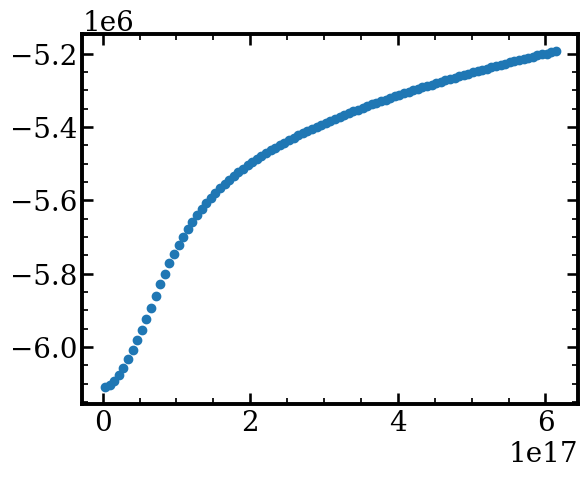

In [118]:
plt.scatter(pos,potentials)

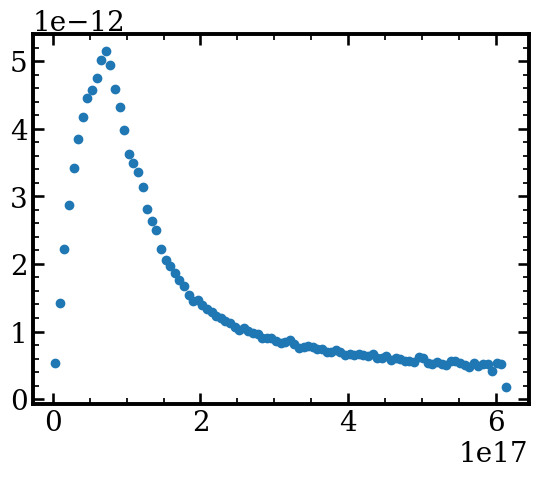

In [119]:
plt.scatter(pos,grad)

# Next step: Calculate circular angular momentum from interpolated potential gradient

In [127]:
# Need to check if this is correct: Calculating only based on x-y distance from subhalo center
# If the star is in the disk, nearly all the angular momentum should be due to motion in the x-y plane
grad_phi_interp = np.abs(gradient_interp(r))

v_circ = np.sqrt(r * grad_phi_interp)

In [128]:
v_circ

array([7.93450966e+01, 2.17677823e+01, 6.34367188e+01, ...,
       3.12505179e+05, 1.57096568e+05, 2.86057850e+05])

In [129]:
star_vel_trans

array([[  -12.637901,     8.943913,    11.446328],
       [  -16.26518 ,    35.235065,    15.416778],
       [   46.98367 ,   -21.21872 ,    36.969025],
       ...,
       [ -729.93835 ,  1077.7594  , -1231.7505  ],
       [ -587.94763 ,   913.9474  , -1462.2476  ],
       [ -751.9747  ,  1056.7695  , -1326.018   ]], dtype=float32)

In [134]:
j_circ = r * v_circ
j_z = np.abs(np.cross(star_coord_trans,star_vel_trans)[:,2])

In [135]:
ratio=j_z/j_circ
ratio

array([0.14451573, 0.29118248, 0.50613443, ..., 0.00136575, 0.00672513,
       0.00233888])

In [136]:
np.min(ratio[~np.isnan(ratio)])

8.089394650427644e-09

In [137]:
np.max(ratio[~np.isnan(ratio)])

342.72145314446146

In [139]:
print(len(ratio[ratio > 0.7]),len(ratio))

512480 3987343


In [140]:
print(len(ratio[ratio > 0.7])/len(ratio))

0.12852669058066987


This halo is calculated to have a ~13% disk component. This feels too small...